# Cauchy (k=1) Instability Diagnosis

Thorough investigation of Gibbs sampler instability for k=1 (Cauchy) at low sample sizes m=6,10,14,20.

**Key finding: two distinct failure modes**
- **Mode 1 — z_acc collapse:** When z_i acceptance rate < 0.6, the x-update step is stuck in z-space, ESS drops to single digits. Dominant at m=6 and m=10 with wide priors.
- **Mode 2 — Prior-likelihood tension:** z_acc looks healthy but ESS is still 20-60 due to prior pulling the posterior away from the likelihood. Occurs at m=10/Moderate, m=14/Tight.

**Structure:**
1. Prior sensitivity sweep (4 priors x 4 sample sizes) with robust diagnostics
2. Root cause diagnostics: two failure modes, var_ratio vs z_acc, empirical z-distribution
3. Per-coordinate x trajectories and spike anatomy
4. Multi-seed stability test with z_acc and ESS tracking

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
from pathlib import Path

parent_dir = Path.cwd().resolve()
if parent_dir.name == 'testing':
    parent_dir = parent_dir.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
os.chdir(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import jax.random as jrandom
from tqdm import tqdm

import jax_gibbs as gs
import utils

plt.rcParams.update({
    'figure.figsize': (14, 5),
    'axes.grid': True,
    'font.size': 11,
})

---
## 1. Prior Sensitivity Sweep

| Prior | prior_std | Variance | Character |
|-------|-----------|----------|-----------|
| Flat  | 20.0      | 400      | Very uninformative |
| Wide  | 10.0      | 100      | Current default |
| Moderate | 5.0    | 25       | Moderately informative |
| Tight | 3.0       | 9        | Informative |

In [2]:
k = 1.0
mu_true = 2.0
T = 30000
burnin = 2000
ms = [6, 10, 14, 20]

prior_configs = {
    'Flat (std=20)':     {'prior_mean': 0.0, 'prior_std': 20.0},
    'Wide (std=10)':     {'prior_mean': 0.0, 'prior_std': 10.0},
    'Moderate (std=5)':  {'prior_mean': 0.0, 'prior_std': 5.0},
    'Tight (std=3)':     {'prior_mean': 0.0, 'prior_std': 3.0},
}

base_sampler = {
    'proposal_std_mu': 0.9,
    'proposal_std_z': 0.03,
}

seed = 42

In [3]:
sweep_results = {}

for m in ms:
    key = jrandom.PRNGKey(seed)
    key, subkey = jrandom.split(key)
    data = jrandom.t(subkey, df=k, shape=(m,)) + mu_true
    mle = utils.get_mle(data, {'k': k, 'm': m})
    print(f'\n{"="*70}')
    print(f'm = {m} | MLE = {mle:.4f} | data range = [{float(data.min()):.2f}, {float(data.max()):.2f}]')
    print(f'{"="*70}')

    for prior_name, prior_cfg in prior_configs.items():
        params = {
            'k': k, 'm': m, 'num_iterations_T': T,
            **base_sampler, **prior_cfg,
        }
        key_gibbs = jrandom.PRNGKey(seed + 1)
        res = gs.run_gibbs_sampler_mle_jax(key_gibbs, mle, params)

        mu_chain = np.array(res['mu_chain'])
        x_chain  = np.array(res['x_chain'])
        mu_post  = mu_chain[burnin:]

        max_abs_x = np.max(np.abs(x_chain[burnin:]), axis=1)

        sweep_results[(m, prior_name)] = {
            'mu_chain': mu_chain,
            'x_chain': x_chain,
            'mu_post': mu_post,
            'max_abs_x': max_abs_x,
            'mle': mle,
            'data': np.array(data),
            'mu_accept': float(res['mu_acceptance_rate']),
            'z_accept': float(res['z_i_acceptance_rate']),
        }
        print(f'  {prior_name:20s} | mu_acc={res["mu_acceptance_rate"]:.3f}'
              f' z_acc={res["z_i_acceptance_rate"]:.3f}'
              f' post_mean={mu_post.mean():.3f} post_std={mu_post.std():.3f}'
              f' max|x|={max_abs_x.max():.1e}')


m = 6 | MLE = 1.8776 | data range = [-0.36, 3.05]


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:24<00:00, 1226.14it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6285
Z_i Acceptance Rate: 0.3647
  Flat (std=20)        | mu_acc=0.628 z_acc=0.365 post_mean=7.851 post_std=17.289 max|x|=1.0e+06


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:22<00:00, 1325.36it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6308
Z_i Acceptance Rate: 0.4812
  Wide (std=10)        | mu_acc=0.631 z_acc=0.481 post_mean=0.747 post_std=12.462 max|x|=2.4e+06


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:22<00:00, 1329.98it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6597
Z_i Acceptance Rate: 0.7279
  Moderate (std=5)     | mu_acc=0.660 z_acc=0.728 post_mean=0.871 post_std=4.583 max|x|=1.0e+06


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:22<00:00, 1326.80it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6533
Z_i Acceptance Rate: 0.7815
  Tight (std=3)        | mu_acc=0.653 z_acc=0.781 post_mean=1.100 post_std=2.061 max|x|=5.9e+05

m = 10 | MLE = 1.4202 | data range = [-1.68, 4.26]


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:24<00:00, 1205.76it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5673
Z_i Acceptance Rate: 0.7889
  Flat (std=20)        | mu_acc=0.567 z_acc=0.789 post_mean=1.342 post_std=0.895 max|x|=8.6e+06


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:23<00:00, 1285.84it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5506
Z_i Acceptance Rate: 0.5305
  Wide (std=10)        | mu_acc=0.551 z_acc=0.531 post_mean=10.284 post_std=8.772 max|x|=1.1e+05


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:23<00:00, 1286.88it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5633
Z_i Acceptance Rate: 0.7696
  Moderate (std=5)     | mu_acc=0.563 z_acc=0.770 post_mean=0.819 post_std=2.238 max|x|=1.7e+05


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:23<00:00, 1288.95it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5568
Z_i Acceptance Rate: 0.7830
  Tight (std=3)        | mu_acc=0.557 z_acc=0.783 post_mean=1.273 post_std=0.869 max|x|=3.4e+05

m = 14 | MLE = 2.4083 | data range = [-0.77, 8.21]


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:25<00:00, 1171.36it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4947
Z_i Acceptance Rate: 0.7748
  Flat (std=20)        | mu_acc=0.495 z_acc=0.775 post_mean=2.407 post_std=0.529 max|x|=1.4e+06


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:24<00:00, 1242.64it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4936
Z_i Acceptance Rate: 0.7809
  Wide (std=10)        | mu_acc=0.494 z_acc=0.781 post_mean=2.394 post_std=0.554 max|x|=1.2e+06


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:24<00:00, 1242.92it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4952
Z_i Acceptance Rate: 0.7780
  Moderate (std=5)     | mu_acc=0.495 z_acc=0.778 post_mean=2.388 post_std=0.540 max|x|=2.9e+06


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:24<00:00, 1246.04it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4936
Z_i Acceptance Rate: 0.7711
  Tight (std=3)        | mu_acc=0.494 z_acc=0.771 post_mean=2.187 post_std=1.087 max|x|=1.5e+05

m = 20 | MLE = 2.0249 | data range = [-6.24, 69.22]


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:26<00:00, 1124.37it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4248
Z_i Acceptance Rate: 0.7803
  Flat (std=20)        | mu_acc=0.425 z_acc=0.780 post_mean=2.021 post_std=0.387 max|x|=2.0e+05


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:26<00:00, 1128.31it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4233
Z_i Acceptance Rate: 0.7819
  Wide (std=10)        | mu_acc=0.423 z_acc=0.782 post_mean=2.015 post_std=0.386 max|x|=3.1e+05


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:25<00:00, 1183.92it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4251
Z_i Acceptance Rate: 0.7754
  Moderate (std=5)     | mu_acc=0.425 z_acc=0.775 post_mean=1.984 post_std=0.460 max|x|=6.6e+05


Running Gibbs Sampler: 100%|██████████| 30000/30000 [00:25<00:00, 1187.70it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.4202
Z_i Acceptance Rate: 0.7835
  Tight (std=3)        | mu_acc=0.420 z_acc=0.783 post_mean=1.986 post_std=0.387 max|x|=1.2e+06


### 1a. Summary table with robust diagnostics

Metrics for comparing Gibbs output to KDE ground truth:
- **KS stat**: Kolmogorov-Smirnov statistic — max |F_Gibbs(x) - F_KDE(x)| — distribution-free, no density estimation needed
- **var_ratio**: Var(Gibbs) / Var(KDE) — should be ~1 if the sampler targets the right distribution
- **mean_diff**: |mean(Gibbs) - mean(KDE)| — bias check
- **ESS**: Effective sample size of the mu chain (measures mixing)

In [4]:
def ess_from_chain(chain):
    """Effective sample size via initial positive sequence estimator (Geyer)."""
    n = len(chain)
    chain = np.asarray(chain, dtype=np.float64)
    mu = chain.mean()
    var = chain.var()
    if var < 1e-30:
        return 0.0
    centered = chain - mu
    # autocorrelation via FFT
    fft_c = np.fft.fft(centered, n=2*n)
    acf_full = np.fft.ifft(fft_c * np.conj(fft_c)).real[:n] / (n * var)
    # Geyer's initial positive sequence: sum consecutive pairs until negative
    tau = 0.0
    for lag in range(1, n, 2):
        pair = acf_full[lag] + (acf_full[lag+1] if lag+1 < n else 0.0)
        if pair < 0:
            break
        tau += pair
    return n / (1.0 + 2.0 * tau)


def ks_against_kde_cdf(samples, kde_pdf, grid_lo=-30, grid_hi=30, n_grid=5000):
    """KS statistic: compare Gibbs samples to CDF derived from KDE posterior density."""
    mu_grid = np.linspace(grid_lo, grid_hi, n_grid)
    pdf_vals = np.maximum(kde_pdf(mu_grid), 1e-30)
    pdf_vals = pdf_vals / np.trapezoid(pdf_vals, mu_grid)
    cdf_vals = np.cumsum(pdf_vals) * (mu_grid[1] - mu_grid[0])
    cdf_vals = cdf_vals / cdf_vals[-1]

    samples_sorted = np.sort(samples)
    cdf_at_samples = np.interp(samples_sorted, mu_grid, cdf_vals)
    n = len(samples_sorted)
    ecdf = np.arange(1, n+1) / n
    ks = np.max(np.abs(ecdf - cdf_at_samples))
    return float(ks)


def kde_mean_var(kde_pdf, grid_lo=-30, grid_hi=30, n_grid=5000):
    """Compute mean and variance of the KDE posterior via numerical integration."""
    mu_grid = np.linspace(grid_lo, grid_hi, n_grid)
    pdf_vals = np.maximum(kde_pdf(mu_grid), 1e-30)
    pdf_vals = pdf_vals / np.trapezoid(pdf_vals, mu_grid)
    mean = np.trapezoid(mu_grid * pdf_vals, mu_grid)
    var = np.trapezoid((mu_grid - mean)**2 * pdf_vals, mu_grid)
    return float(mean), float(var)


# Compute KDE posteriors once and cache for reuse in later cells
kde_cache = {}

rows = []
for (m, prior_name), r in sweep_results.items():
    prior_cfg = prior_configs[prior_name]
    kde_params = {'k': k, 'm': m, **prior_cfg, 'kde_bw_method': 0.001}
    mle_samples = utils.get_benchmark_mle_samples(kde_params, num_simulations=10000)
    kde_pdf = utils.get_normalized_posterior_mle_pdf(r['mle'], kde_params, mle_samples=mle_samples)
    kde_cache[(m, prior_name)] = kde_pdf

    kde_mean, kde_var = kde_mean_var(kde_pdf)
    ks_stat = ks_against_kde_cdf(r['mu_post'], kde_pdf)
    var_ratio = r['mu_post'].var() / kde_var if kde_var > 0 else np.nan
    mean_diff = abs(r['mu_post'].mean() - kde_mean)
    ess = ess_from_chain(r['mu_post'])

    rows.append({
        'm': m,
        'Prior': prior_name,
        'mu_acc': f"{r['mu_accept']:.3f}",
        'post_mean': f"{r['mu_post'].mean():.2f}",
        'post_std': f"{r['mu_post'].std():.2f}",
        'KS stat': f'{ks_stat:.3f}',
        'var_ratio': f'{var_ratio:.3f}',
        'mean_diff': f'{mean_diff:.3f}',
        'ESS': f'{ess:.0f}',
        'max|x|': f"{r['max_abs_x'].max():.1e}",
        'pct |x|>100': f"{100*np.mean(r['max_abs_x'] > 100):.1f}%",
    })

df_summary = pd.DataFrame(rows)
df_summary


--- Computing Benchmark KDE from 10000 simulations ---
  Processing simulation 10000/10000...
Fitting KDE to MLE samples using bw_method = 0.001


/Users/shlokmishra/code/student_t_mle/utils.py:93: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda mu: np.exp(log_unnorm(mu)), -np.inf, np.inf)



--- Computing Benchmark KDE from 10000 simulations ---
  Processing simulation 10000/10000...
Fitting KDE to MLE samples using bw_method = 0.001

--- Computing Benchmark KDE from 10000 simulations ---
  Processing simulation 10000/10000...
Fitting KDE to MLE samples using bw_method = 0.001

--- Computing Benchmark KDE from 10000 simulations ---
  Processing simulation 10000/10000...
Fitting KDE to MLE samples using bw_method = 0.001

--- Computing Benchmark KDE from 10000 simulations ---
  Processing simulation 10000/10000...
Fitting KDE to MLE samples using bw_method = 0.001

--- Computing Benchmark KDE from 10000 simulations ---
  Processing simulation 10000/10000...
Fitting KDE to MLE samples using bw_method = 0.001

--- Computing Benchmark KDE from 10000 simulations ---
  Processing simulation 10000/10000...
Fitting KDE to MLE samples using bw_method = 0.001

--- Computing Benchmark KDE from 10000 simulations ---
  Processing simulation 10000/10000...
Fitting KDE to MLE samples us

,m,Prior,mu_acc,post_mean,post_std,KS stat,var_ratio,mean_diff,ESS,max|x|,pct |x|>100
0,6,Flat (std=20),0.628,7.85,17.29,0.606,124.650,6.011,4,1.0e+06,4.3%
1,6,Wide (std=10),0.631,0.75,12.46,0.418,107.787,1.103,6,2.4e+06,4.7%
2,6,Moderate (std=5),0.660,0.87,4.58,0.253,26.822,0.948,25,1.0e+06,4.3%
3,6,Tight (std=3),0.653,1.10,2.06,0.190,6.636,0.635,77,5.9e+05,4.7%
4,10,Flat (std=20),0.567,1.34,0.89,0.061,0.551,0.061,318,8.6e+06,7.5%
5,10,Wide (std=10),0.551,10.28,8.77,0.563,151.827,8.877,3,1.1e+05,9.7%
6,10,Moderate (std=5),0.563,0.82,2.24,0.117,15.631,0.589,21,1.7e+05,7.6%
7,10,Tight (std=3),0.557,1.27,0.87,0.063,2.652,0.092,453,3.4e+05,7.2%
8,14,Flat (std=20),0.495,2.41,0.53,0.032,0.494,0.011,3474,1.4e+06,9.3%
9,14,Wide (std=10),0.494,2.39,0.55,0.040,1.164,0.010,2372,1.2e+06,9.9%


In [5]:
# Pivot tables for the key diagnostics
df_piv = pd.DataFrame(rows)
print('KS statistic (lower = better match with KDE ground truth):')
print(df_piv.pivot(index='m', columns='Prior', values='KS stat'))
print()
print('Variance ratio Var(Gibbs)/Var(KDE) — should be ~1:')
print(df_piv.pivot(index='m', columns='Prior', values='var_ratio'))
print()
print('Effective sample size (out of', T - burnin, 'post-burnin iterations):')
print(df_piv.pivot(index='m', columns='Prior', values='ESS'))
print()
print('Pct iterations with |x| > 100:')
print(df_piv.pivot(index='m', columns='Prior', values='pct |x|>100'))

KS statistic (lower = better match with KDE ground truth):
Prior Flat (std=20) Moderate (std=5) Tight (std=3) Wide (std=10)
m                                                               
6             0.606            0.253         0.190         0.418
10            0.061            0.117         0.063         0.563
14            0.032            0.039         0.057         0.040
20            0.027            0.032         0.029         0.027

Variance ratio Var(Gibbs)/Var(KDE) — should be ~1:
Prior Flat (std=20) Moderate (std=5) Tight (std=3) Wide (std=10)
m                                                               
6           124.650           26.822         6.636       107.787
10            0.551           15.631         2.652       151.827
14            0.494            1.598         6.434         1.164
20            1.052            1.791         1.312         1.175

Effective sample size (out of 28000 post-burnin iterations):
Prior Flat (std=20) Moderate (std=5) Tight (std

### 1b. Trace plots: mu chain by prior and m

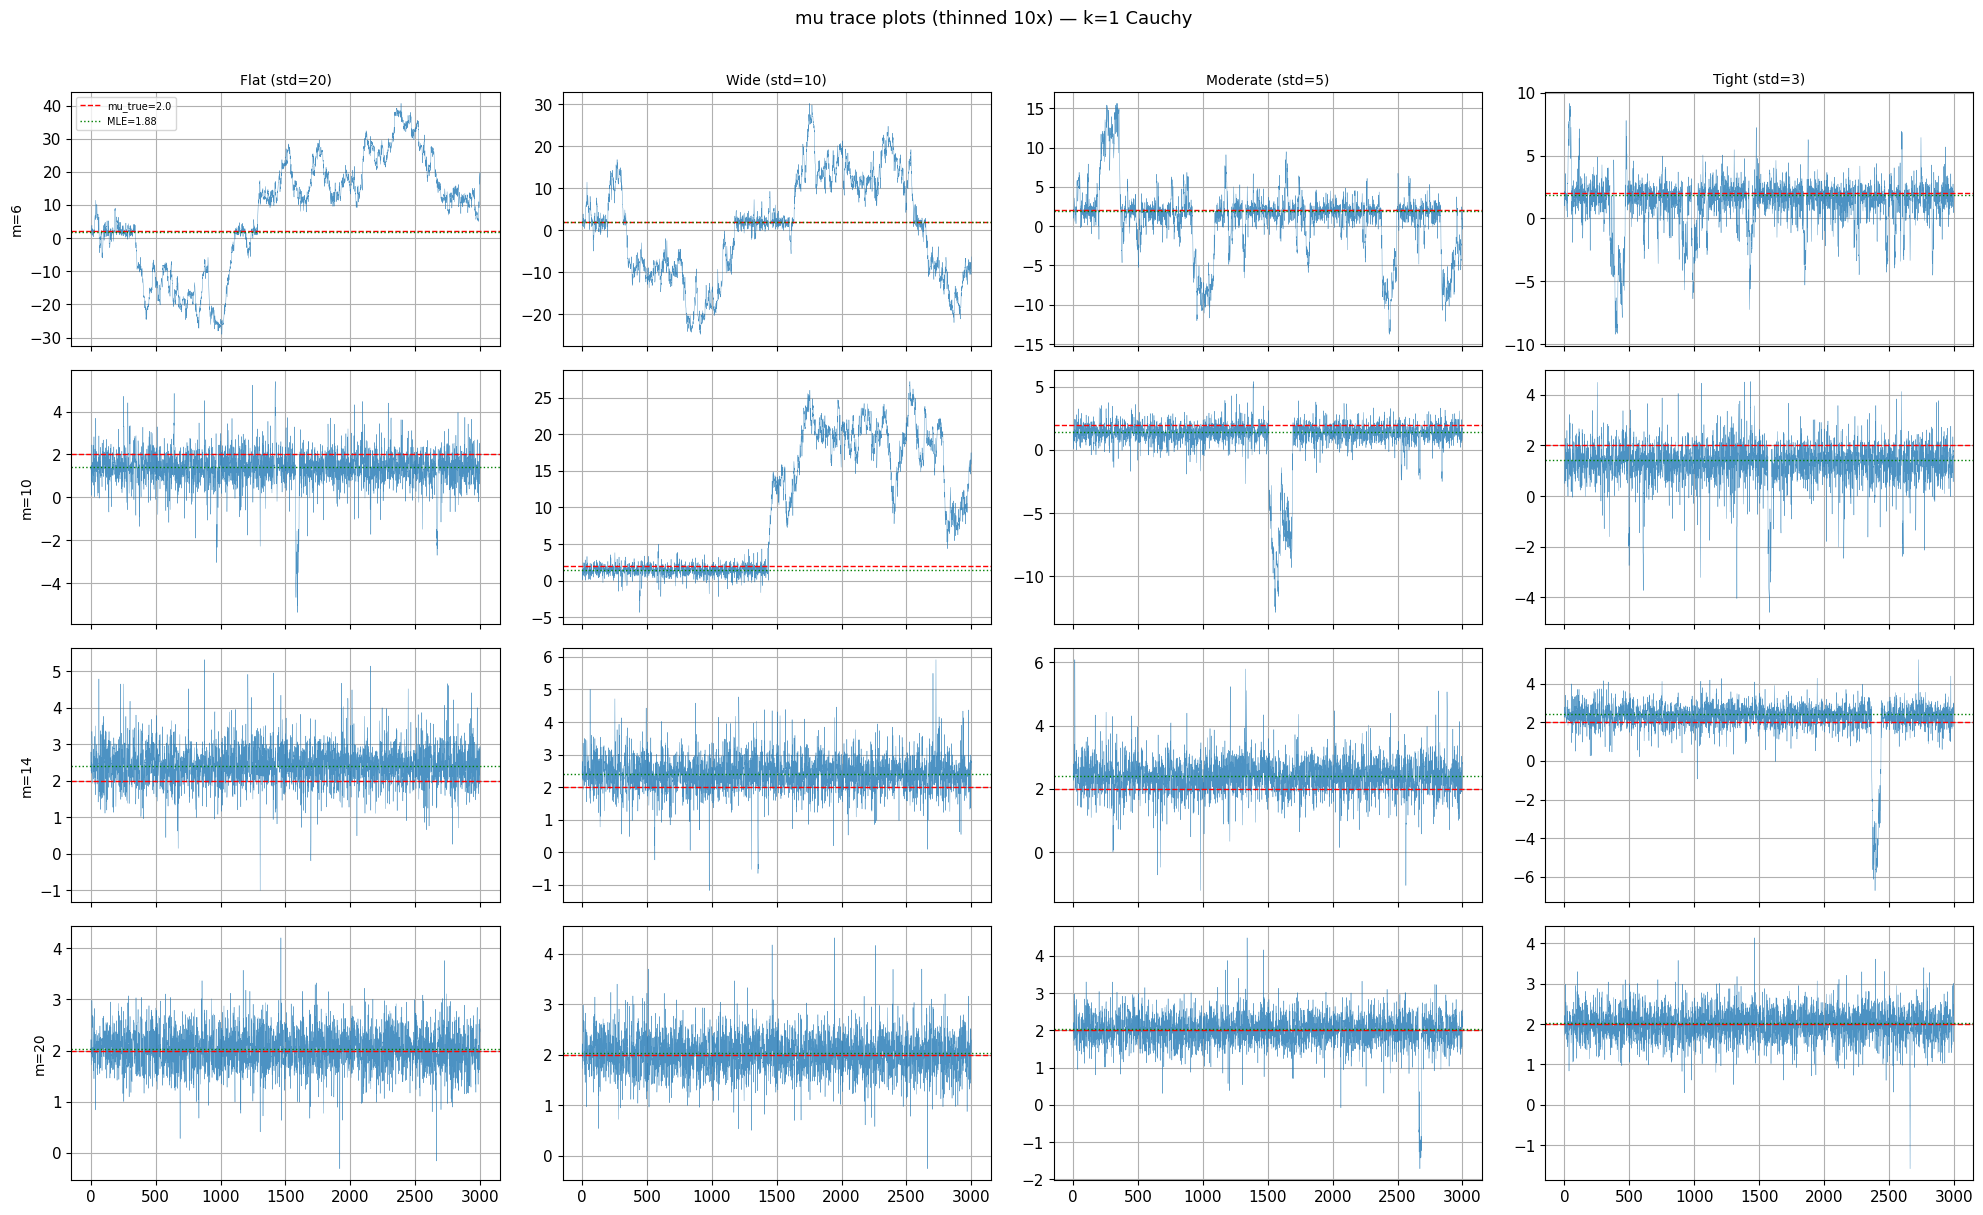

In [6]:
fig, axes = plt.subplots(len(ms), len(prior_configs), figsize=(20, 3*len(ms)),
                         sharex=True, squeeze=False)
for i, m in enumerate(ms):
    for j, prior_name in enumerate(prior_configs):
        ax = axes[i][j]
        r = sweep_results[(m, prior_name)]
        ax.plot(r['mu_chain'][::10], lw=0.3, alpha=0.8)
        ax.axhline(mu_true, color='r', ls='--', lw=1, label=f'mu_true={mu_true}')
        ax.axhline(r['mle'], color='g', ls=':', lw=1, label=f'MLE={r["mle"]:.2f}')
        if i == 0:
            ax.set_title(prior_name, fontsize=10)
        if j == 0:
            ax.set_ylabel(f'm={m}', fontsize=10)
        if i == 0 and j == 0:
            ax.legend(fontsize=7)
fig.suptitle('mu trace plots (thinned 10x) — k=1 Cauchy', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### 1c. max|x| over iterations (stability diagnostic)

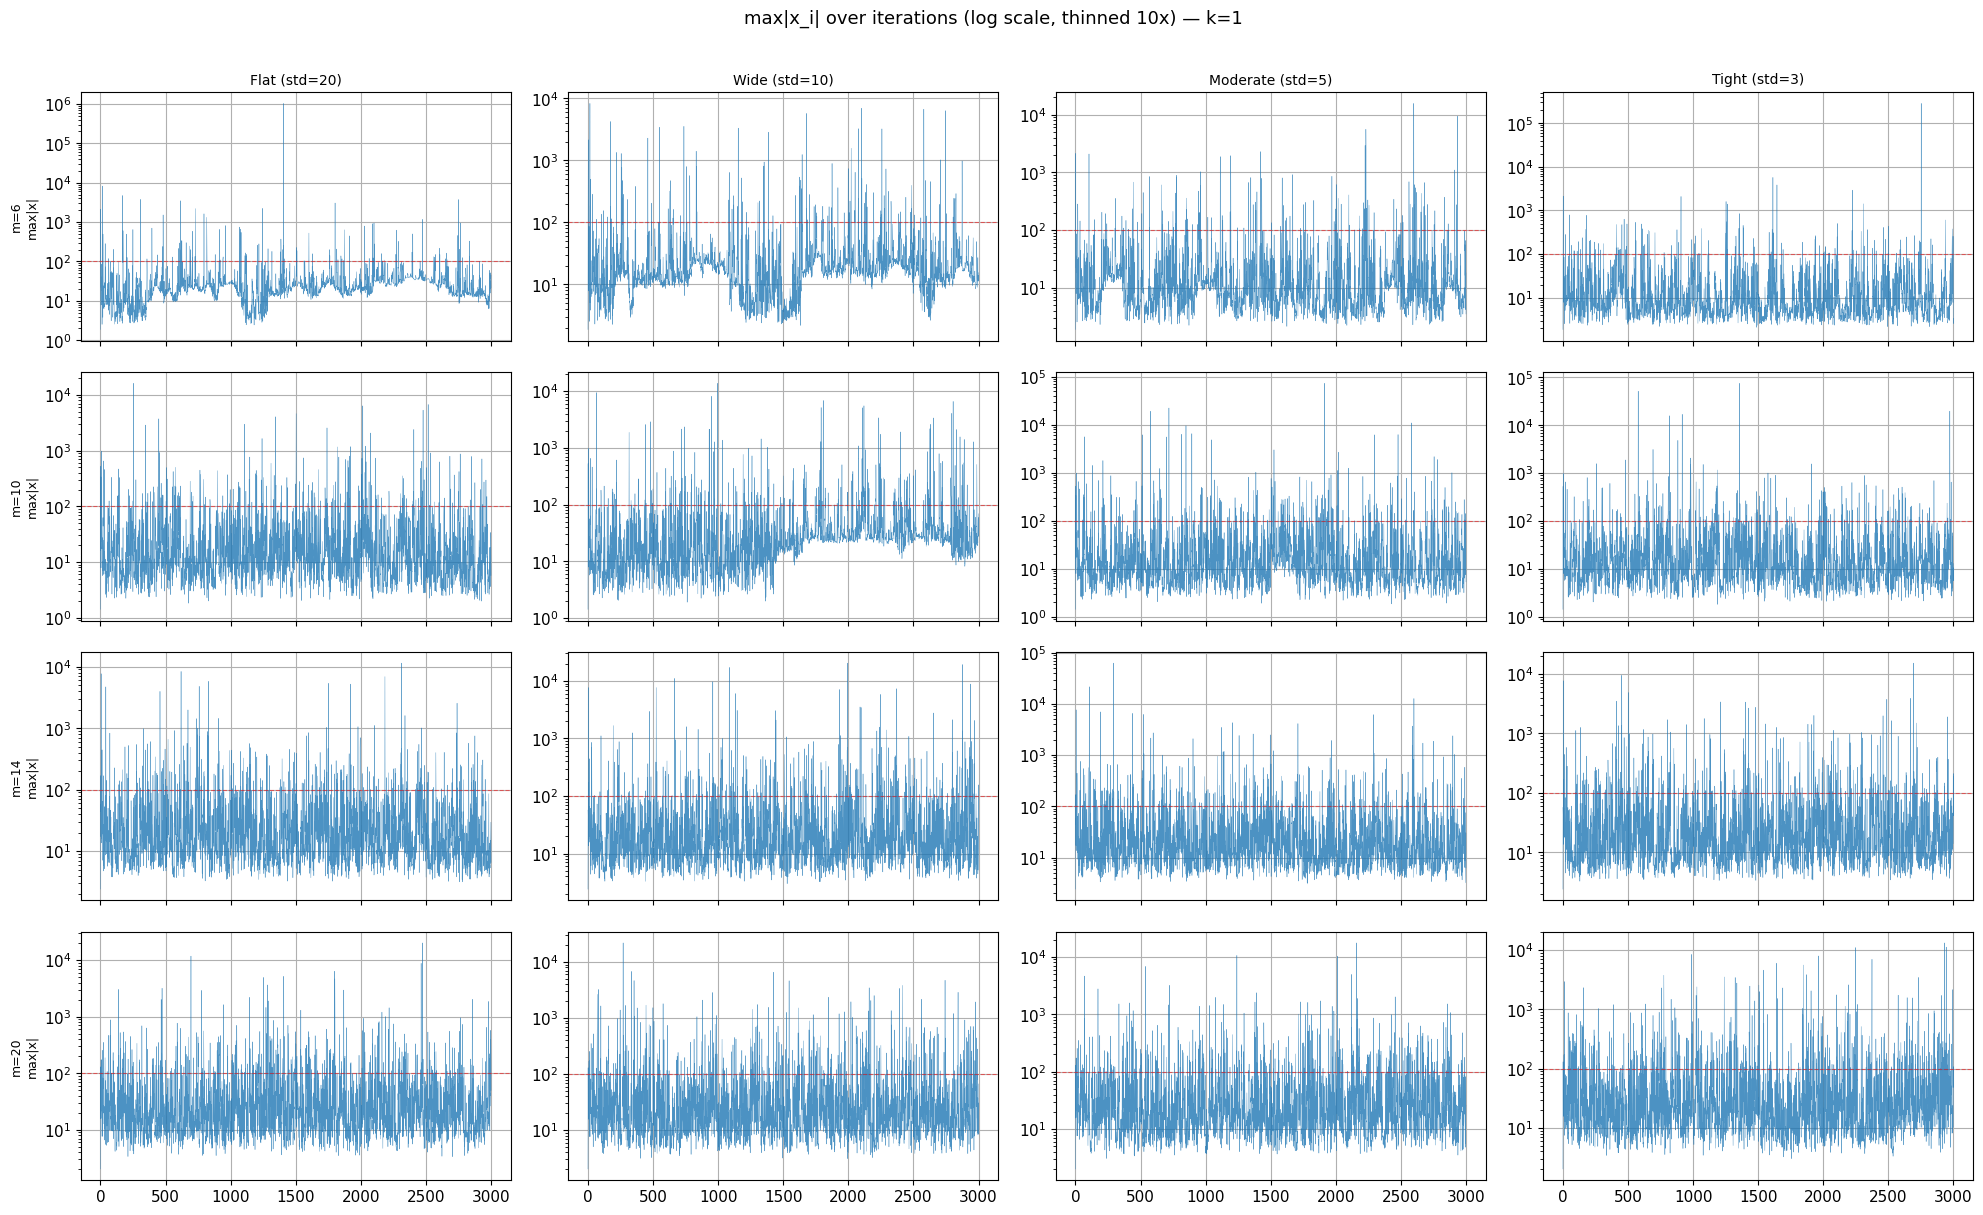

In [7]:
fig, axes = plt.subplots(len(ms), len(prior_configs), figsize=(20, 3*len(ms)),
                         sharex=True, squeeze=False)
for i, m in enumerate(ms):
    for j, prior_name in enumerate(prior_configs):
        ax = axes[i][j]
        r = sweep_results[(m, prior_name)]
        max_abs = np.max(np.abs(r['x_chain']), axis=1)
        ax.semilogy(max_abs[::10], lw=0.3, alpha=0.8)
        ax.axhline(100, color='r', ls='--', lw=0.8, alpha=0.5)
        if i == 0:
            ax.set_title(prior_name, fontsize=10)
        if j == 0:
            ax.set_ylabel(f'm={m}\nmax|x|', fontsize=9)
fig.suptitle('max|x_i| over iterations (log scale, thinned 10x) — k=1', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### 1d. Posterior densities: Gibbs vs KDE (focus on m=6 and m=10)

Only showing the problematic cases (m=6, m=10) where the prior matters.

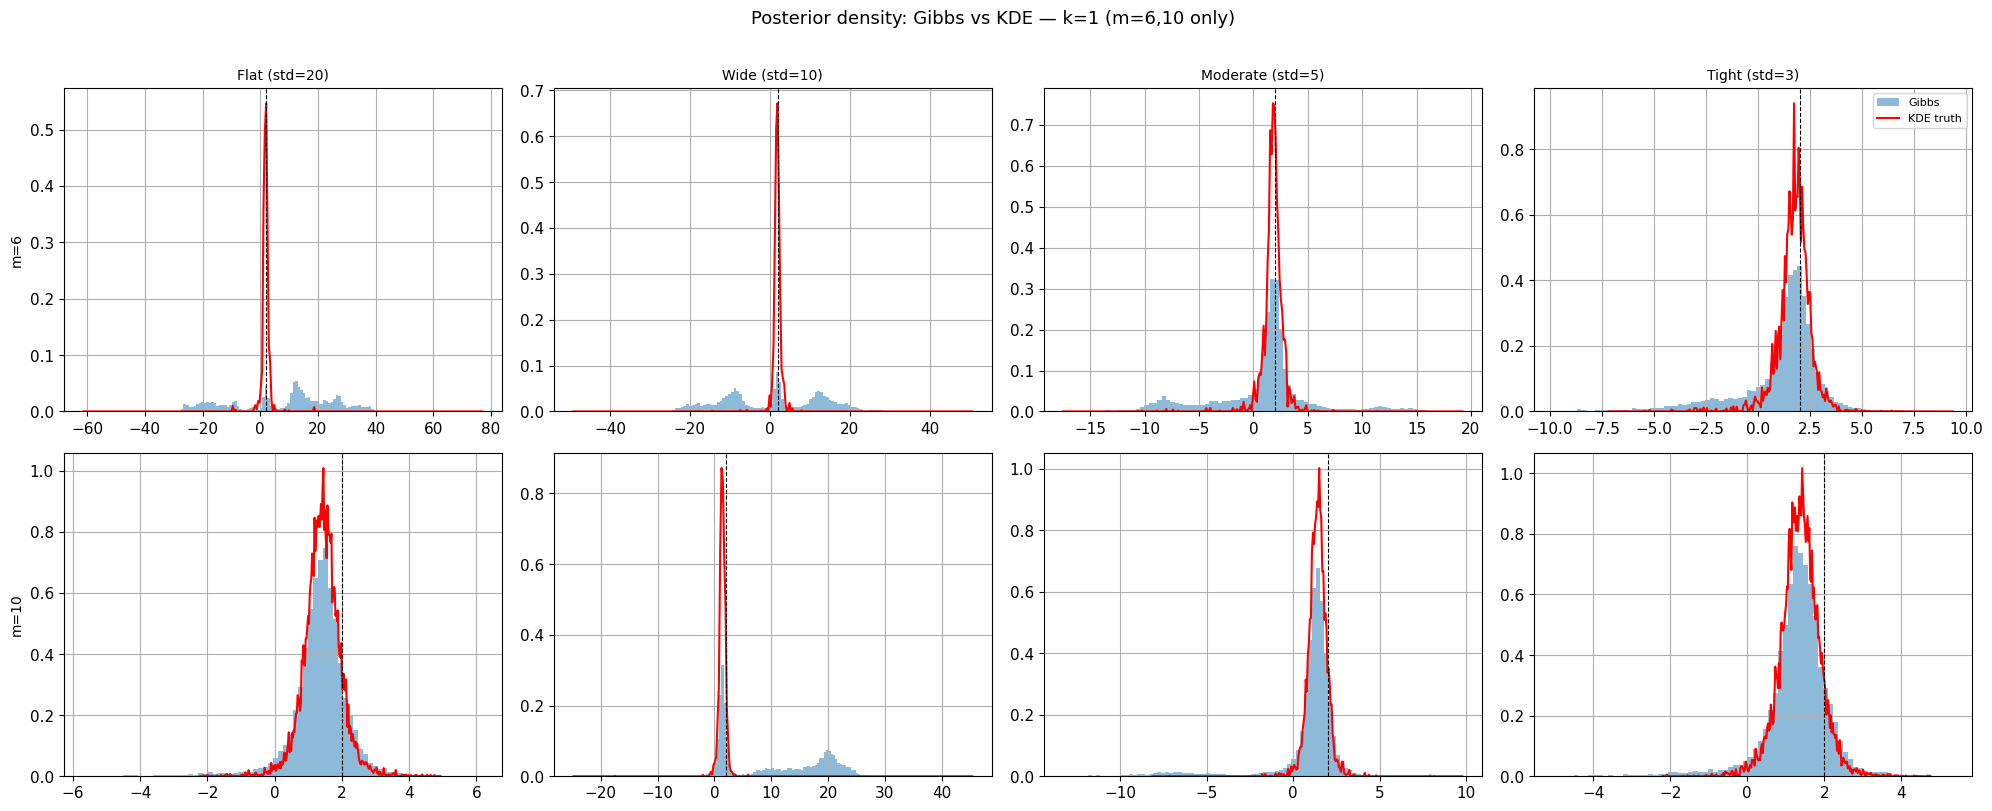

In [8]:
focus_ms = [6, 10]
fig, axes = plt.subplots(len(focus_ms), len(prior_configs), figsize=(20, 4*len(focus_ms)),
                         squeeze=False)

for i, m in enumerate(focus_ms):
    for j, prior_name in enumerate(prior_configs):
        ax = axes[i][j]
        r = sweep_results[(m, prior_name)]
        kde_pdf = kde_cache[(m, prior_name)]

        mu_grid = np.linspace(r['mu_post'].mean() - 4*r['mu_post'].std(),
                              r['mu_post'].mean() + 4*r['mu_post'].std(), 300)
        kde_vals = kde_pdf(mu_grid)

        ax.hist(r['mu_post'], bins=80, density=True, alpha=0.5, label='Gibbs')
        ax.plot(mu_grid, kde_vals, 'r-', lw=1.5, label='KDE truth')
        ax.axvline(mu_true, color='k', ls='--', lw=0.8)
        if i == 0:
            ax.set_title(prior_name, fontsize=10)
        if j == 0:
            ax.set_ylabel(f'm={m}', fontsize=10)
        if i == 0 and j == len(prior_configs)-1:
            ax.legend(fontsize=8)

fig.suptitle('Posterior density: Gibbs vs KDE — k=1 (m=6,10 only)', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

---
## 2. Root Cause Diagnostics

### 2a. Two distinct failure modes

The sweep reveals **two distinct mechanisms** that cause the Gibbs sampler to fail:

**Mode 1 — Low z_i acceptance rate (z_acc < 0.6):** The pairwise x-update step gets stuck. The sampler cannot explore z-space, ESS collapses to single digits. This happens at m=6 with Flat/Wide priors and at m=10 with Wide prior. It is the dominant failure mode.

**Mode 2 — Prior-likelihood tension (z_acc good, ESS still low):** Even when z_acc is ~0.77 (normal range), some configurations have ESS of only 20–60. Examples: m=10/Moderate (ESS=21), m=14/Tight (ESS=57), m=20/Moderate (ESS=425). Here the prior fights the likelihood, inflating variance ratio well above 1 and creating slow mixing even though acceptance rates look healthy.

**Counterintuitive trend:** pct |x|>100 **increases** with m (4% at m=6 → 12% at m=20), yet the sampler works dramatically better at larger m. More data → tighter MLE → mu-posterior less sensitive to x-explosions.

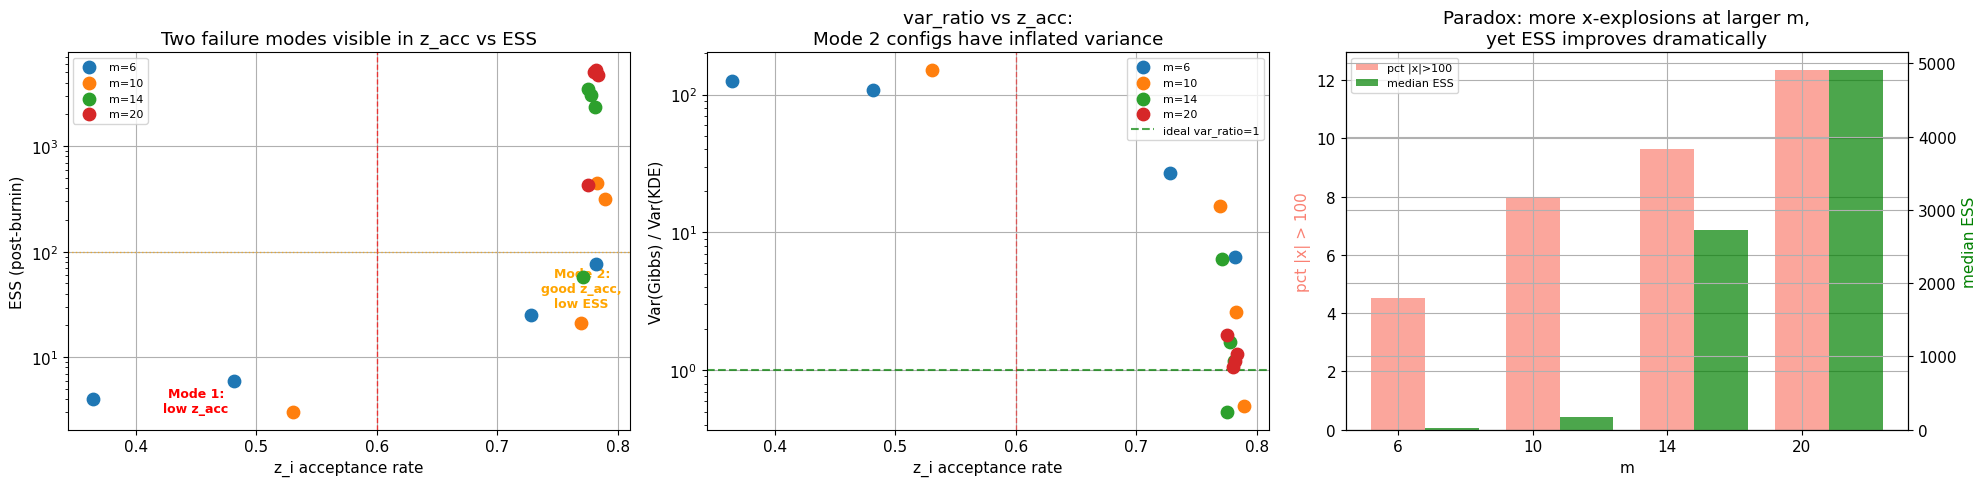

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

z_accs = [r['z_accept'] for r in sweep_results.values()]
ess_vals = [float(row['ESS']) for row in rows]
var_ratios = [float(row['var_ratio']) for row in rows]
m_vals = [r_key[0] for r_key in sweep_results.keys()]
prior_labels = [r_key[1] for r_key in sweep_results.keys()]

# (a) z_acc vs ESS — two failure modes
for m_val in ms:
    mask = [m == m_val for m in m_vals]
    x_pts = [z for z, f in zip(z_accs, mask) if f]
    y_pts = [e for e, f in zip(ess_vals, mask) if f]
    axes[0].scatter(x_pts, y_pts, s=80, label=f'm={m_val}', zorder=5)

axes[0].axvline(0.6, color='r', ls='--', lw=1, alpha=0.7)
axes[0].axhline(100, color='orange', ls=':', lw=1, alpha=0.7)
axes[0].annotate('Mode 1:\nlow z_acc', xy=(0.45, 3), fontsize=9, color='red',
                 ha='center', fontweight='bold')
axes[0].annotate('Mode 2:\ngood z_acc,\nlow ESS', xy=(0.77, 30), fontsize=9, color='orange',
                 ha='center', fontweight='bold')
axes[0].set_xlabel('z_i acceptance rate')
axes[0].set_ylabel('ESS (post-burnin)')
axes[0].set_title('Two failure modes visible in z_acc vs ESS')
axes[0].legend(fontsize=8)
axes[0].set_yscale('log')

# (b) var_ratio vs z_acc — prior-likelihood tension visible even at good z_acc
for m_val in ms:
    mask = [m == m_val for m in m_vals]
    x_pts = [z for z, f in zip(z_accs, mask) if f]
    y_pts = [v for v, f in zip(var_ratios, mask) if f]
    axes[1].scatter(x_pts, y_pts, s=80, label=f'm={m_val}', zorder=5)

axes[1].axhline(1.0, color='green', ls='--', lw=1.5, alpha=0.7, label='ideal var_ratio=1')
axes[1].axvline(0.6, color='r', ls='--', lw=1, alpha=0.5)
axes[1].set_xlabel('z_i acceptance rate')
axes[1].set_ylabel('Var(Gibbs) / Var(KDE)')
axes[1].set_title('var_ratio vs z_acc:\nMode 2 configs have inflated variance')
axes[1].set_yscale('log')
axes[1].legend(fontsize=8)

# (c) pct |x|>100 vs m — the counterintuitive trend
pct_by_m = {}
for (m_val, pname), r in sweep_results.items():
    pct = 100 * np.mean(r['max_abs_x'] > 100)
    pct_by_m.setdefault(m_val, []).append(pct)

m_plot = sorted(pct_by_m.keys())
pct_means = [np.mean(pct_by_m[m]) for m in m_plot]

ess_by_m = {}
for (m_val, pname), r in sweep_results.items():
    ess_by_m.setdefault(m_val, []).append(ess_from_chain(r['mu_post']))
ess_medians = [np.median(ess_by_m[m]) for m in m_plot]

ax_twin = axes[2].twinx()
b1 = axes[2].bar([x - 0.2 for x in range(len(m_plot))], pct_means, width=0.4,
                  tick_label=[str(m) for m in m_plot], alpha=0.7, color='salmon', label='pct |x|>100')
b2 = ax_twin.bar([x + 0.2 for x in range(len(m_plot))], ess_medians, width=0.4,
                  alpha=0.7, color='green', label='median ESS')
axes[2].set_xlabel('m')
axes[2].set_ylabel('pct |x| > 100', color='salmon')
ax_twin.set_ylabel('median ESS', color='green')
axes[2].set_title('Paradox: more x-explosions at larger m,\nyet ESS improves dramatically')
axes[2].legend(handles=[b1, b2], fontsize=8, loc='upper left')

plt.tight_layout()
plt.show()

### 2b. Empirical z-distribution from the chain

Compute $z_i = \psi(x_i - \mu^*)$ for all coordinates across the chain. The empirical z-distribution should resemble the U-shaped $q(z)$ if the sampler is working correctly. Deviation indicates the x-update step is getting stuck.

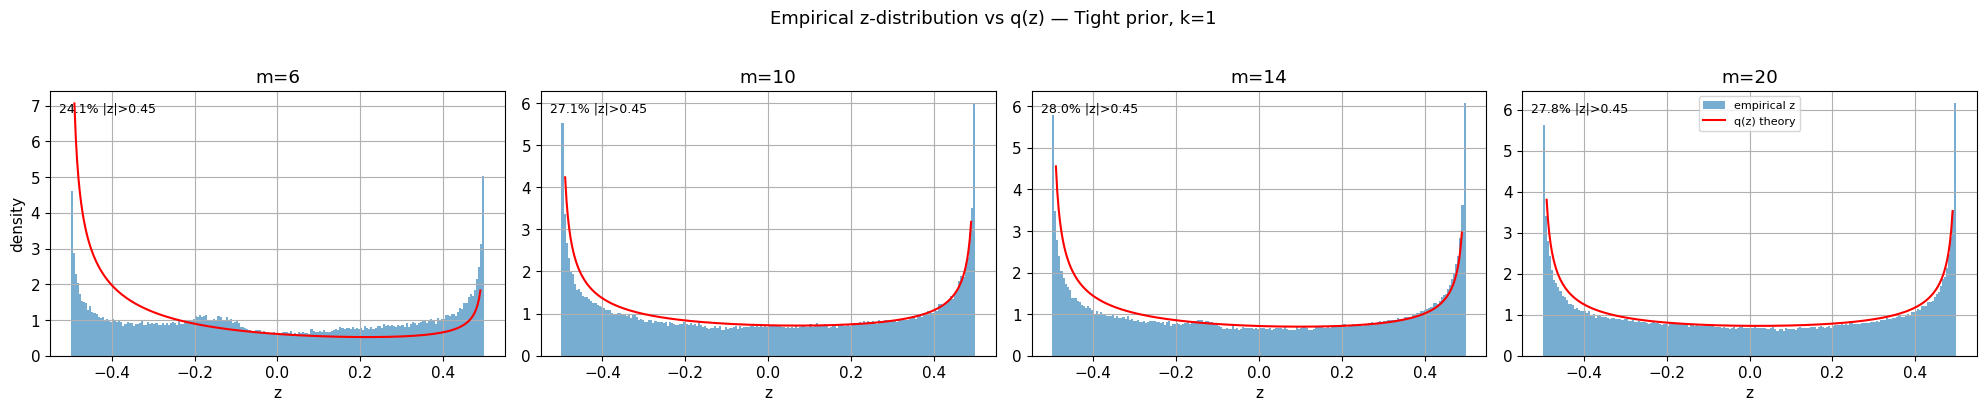

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for idx, m in enumerate(ms):
    ax = axes[idx]
    r = sweep_results[(m, 'Tight (std=3)')]
    x_post = r['x_chain'][burnin:]
    y_all = x_post - r['mle']
    z_all = y_all / (k + y_all**2)
    z_flat = z_all.flatten()

    # Clip for histogram visibility
    z_clipped = z_flat[(z_flat > -0.499) & (z_flat < 0.499)]
    ax.hist(z_clipped, bins=200, density=True, alpha=0.6, label='empirical z')

    # Overlay theoretical q(z)
    z_grid_th = np.linspace(-0.49, 0.49, 300)
    log_q = np.array([float(gs.q_logpdf_jax(
        jnp.float64(z), jnp.float64(r['mu_post'].mean()),
        jnp.float64(r['mle']), jnp.float64(k)
    )) for z in z_grid_th])
    q_th = np.exp(log_q - log_q.max())
    q_th /= np.trapezoid(q_th, z_grid_th)
    ax.plot(z_grid_th, q_th, 'r-', lw=1.5, label='q(z) theory')

    ax.set_title(f'm={m}')
    ax.set_xlabel('z')
    if idx == 0:
        ax.set_ylabel('density')
    if idx == 3:
        ax.legend(fontsize=8)

    pct_extreme = 100 * np.mean(np.abs(z_flat) > 0.45)
    ax.annotate(f'{pct_extreme:.1f}% |z|>0.45', xy=(0.02, 0.92),
                xycoords='axes fraction', fontsize=9)

fig.suptitle('Empirical z-distribution vs q(z) — Tight prior, k=1', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 3. Per-Coordinate x Trajectories

Track each x_i individually to see which coordinates explode, whether the same coordinate repeatedly hits extreme values, and how long extreme states persist.

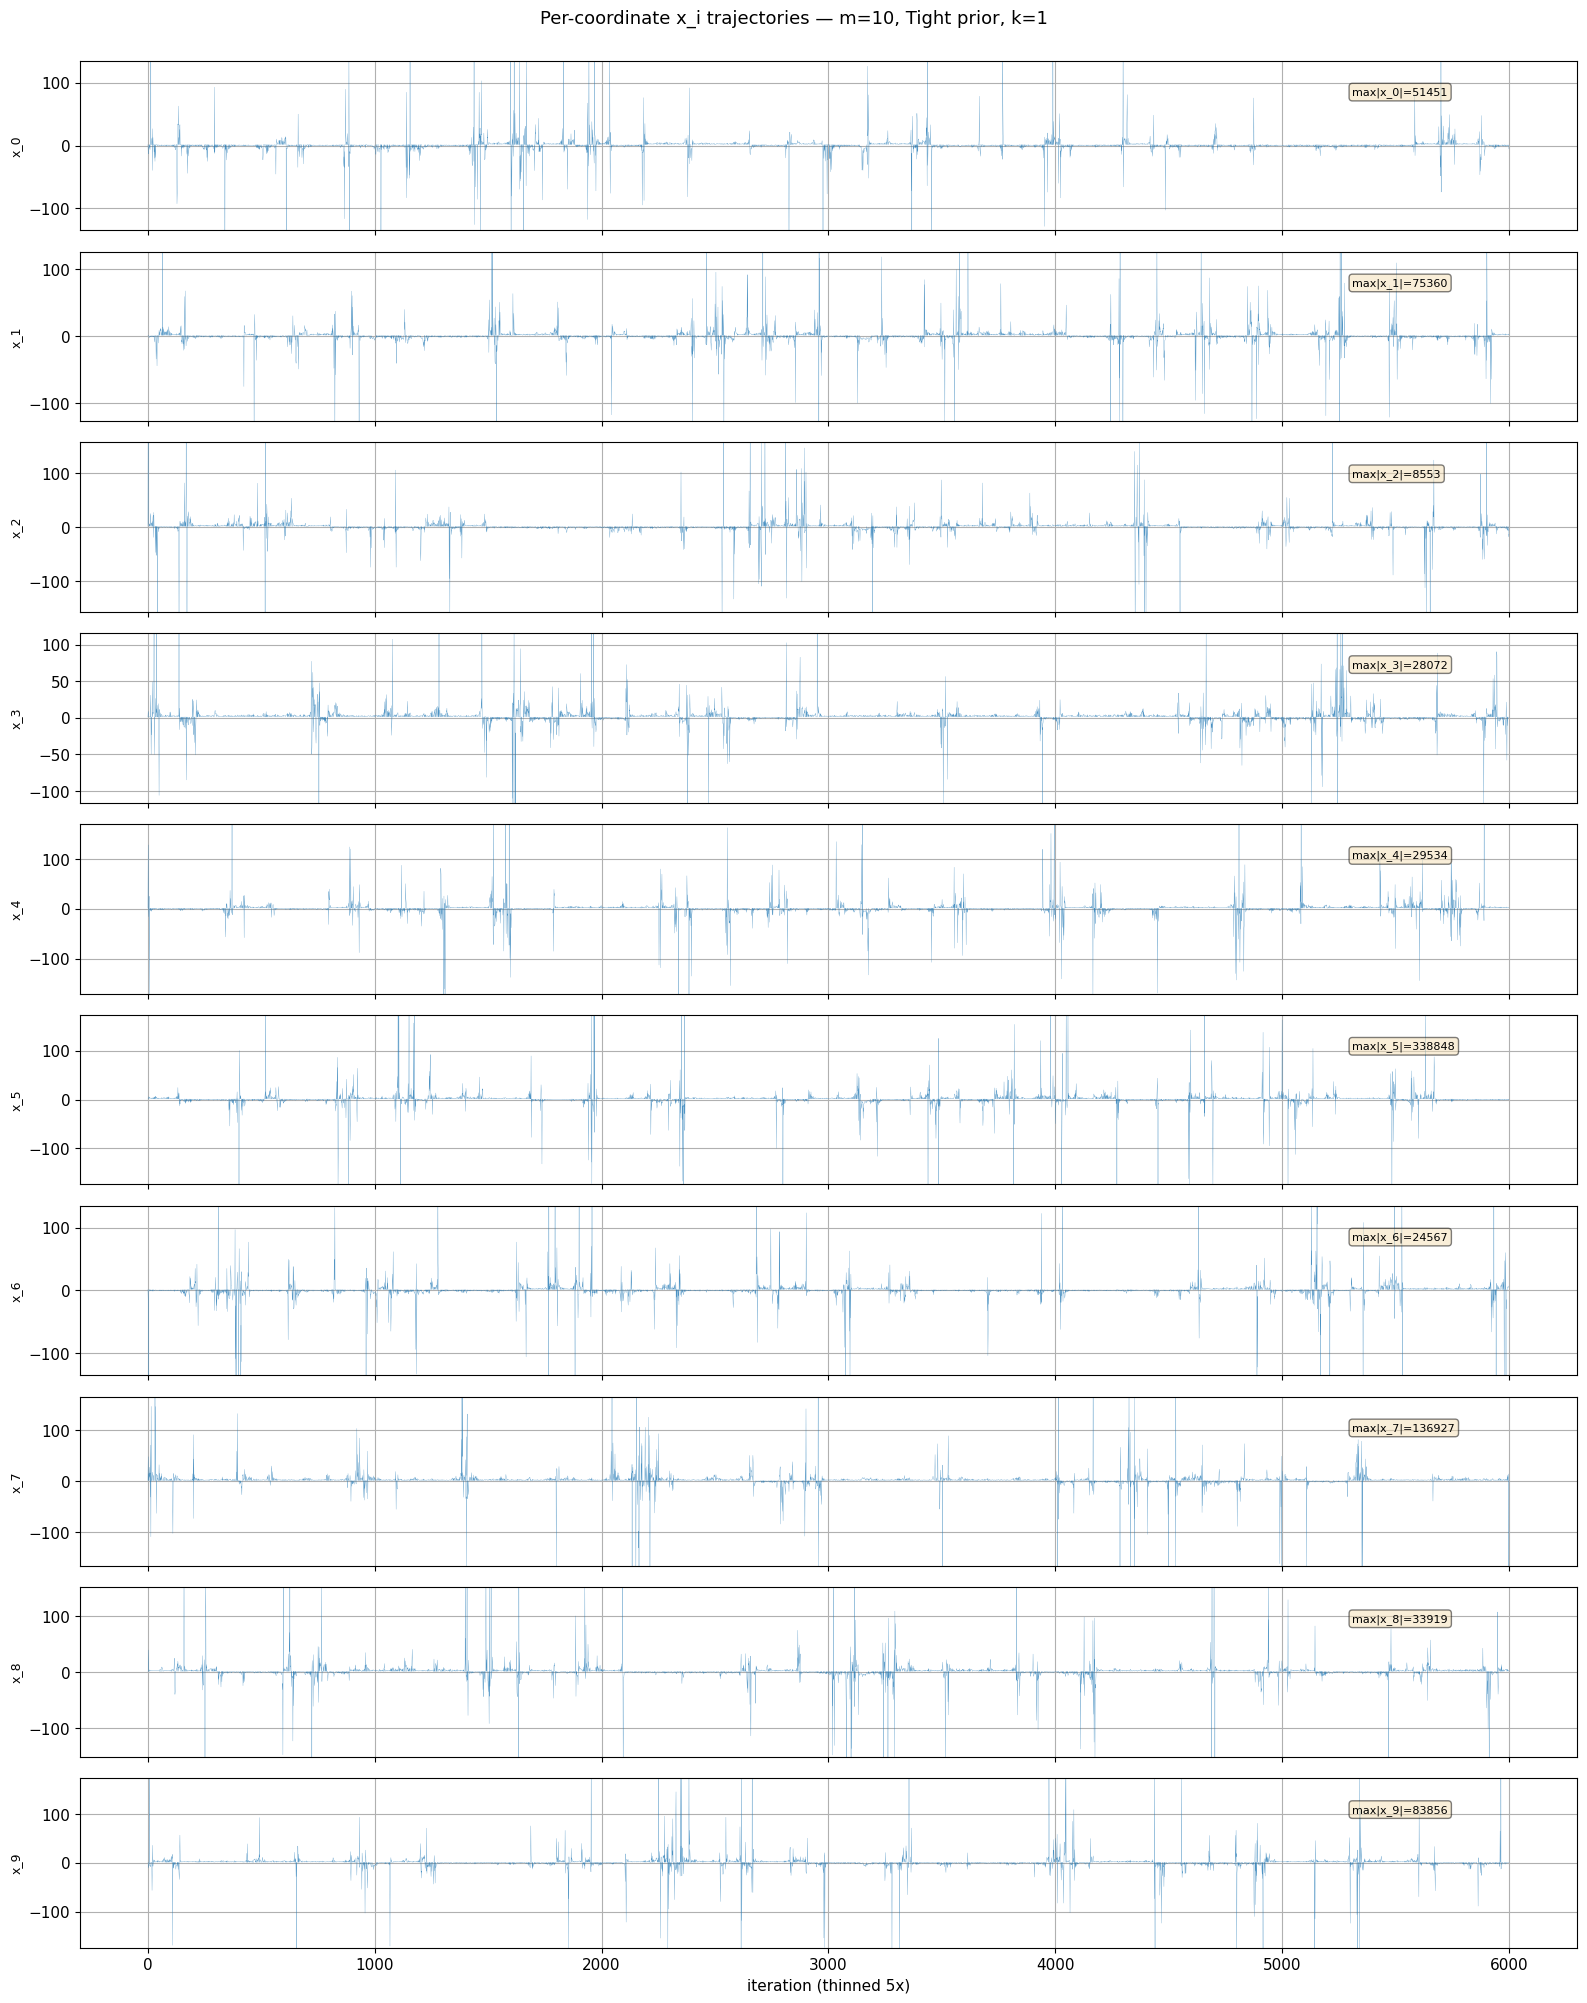

In [11]:
# Focus: m=10, Tight prior (best-case scenario for stability)
r_focus = sweep_results[(10, 'Tight (std=3)')]
x_chain = r_focus['x_chain']
m_focus = 10

fig, axes = plt.subplots(m_focus, 1, figsize=(16, 2*m_focus), sharex=True)
for i in range(m_focus):
    axes[i].plot(x_chain[::5, i], lw=0.2, alpha=0.8)
    axes[i].set_ylabel(f'x_{i}', fontsize=9)
    ymax = np.percentile(np.abs(x_chain[:, i]), 99.5)
    axes[i].set_ylim(-ymax, ymax)
    max_val = np.max(np.abs(x_chain[:, i]))
    axes[i].annotate(f'max|x_{i}|={max_val:.0f}', xy=(0.85, 0.8),
                     xycoords='axes fraction', fontsize=8,
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('iteration (thinned 5x)')
fig.suptitle(f'Per-coordinate x_i trajectories — m={m_focus}, Tight prior, k=1', fontsize=13, y=1.0)
plt.tight_layout()
plt.show()

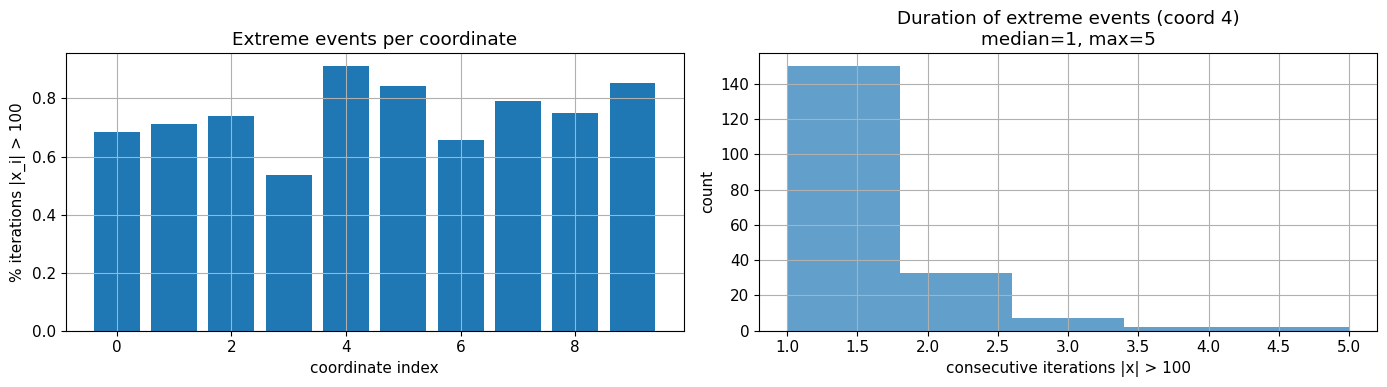

In [12]:
# Which coordinates are responsible for extreme events?
threshold = 100
extreme_counts = np.sum(np.abs(x_chain[burnin:]) > threshold, axis=0)
total_iters = x_chain.shape[0] - burnin

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].bar(range(m_focus), extreme_counts / total_iters * 100)
axes[0].set_xlabel('coordinate index')
axes[0].set_ylabel(f'% iterations |x_i| > {threshold}')
axes[0].set_title('Extreme events per coordinate')

# Duration of extreme events: consecutive iterations where |x_i| > threshold for the worst coordinate
worst_coord = np.argmax(extreme_counts)
is_extreme = np.abs(x_chain[burnin:, worst_coord]) > threshold
runs = []
run_len = 0
for v in is_extreme:
    if v:
        run_len += 1
    elif run_len > 0:
        runs.append(run_len)
        run_len = 0
if run_len > 0:
    runs.append(run_len)

if runs:
    axes[1].hist(runs, bins=min(50, max(runs)), alpha=0.7)
    axes[1].set_xlabel('consecutive iterations |x| > 100')
    axes[1].set_ylabel('count')
    axes[1].set_title(f'Duration of extreme events (coord {worst_coord})\n'
                      f'median={np.median(runs):.0f}, max={max(runs)}')
else:
    axes[1].text(0.5, 0.5, 'No extreme events', ha='center', va='center',
                 transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

### 3a. Zoom: anatomy of a single extreme event

Pick the first time max|x| exceeds 1000 and show what happens to all coordinates, mu, and the constraint around that point.

Spike at iter 97: coordinate 0 = -20269.1
x before: [  1.41880463   0.04042981   1.57223462  24.57091844  -1.21931107
   2.153674    -1.06483595  14.19676447   2.61578048 -10.35559602]
x after:  [-2.02690511e+04 -3.16971493e-02  1.57666111e+00  1.45535985e+00
  1.02523881e+00  2.59159888e+00 -1.17039039e+00  1.49709753e+00
  2.22173079e+00 -8.35708602e+00]
mu at spike: 1.8811


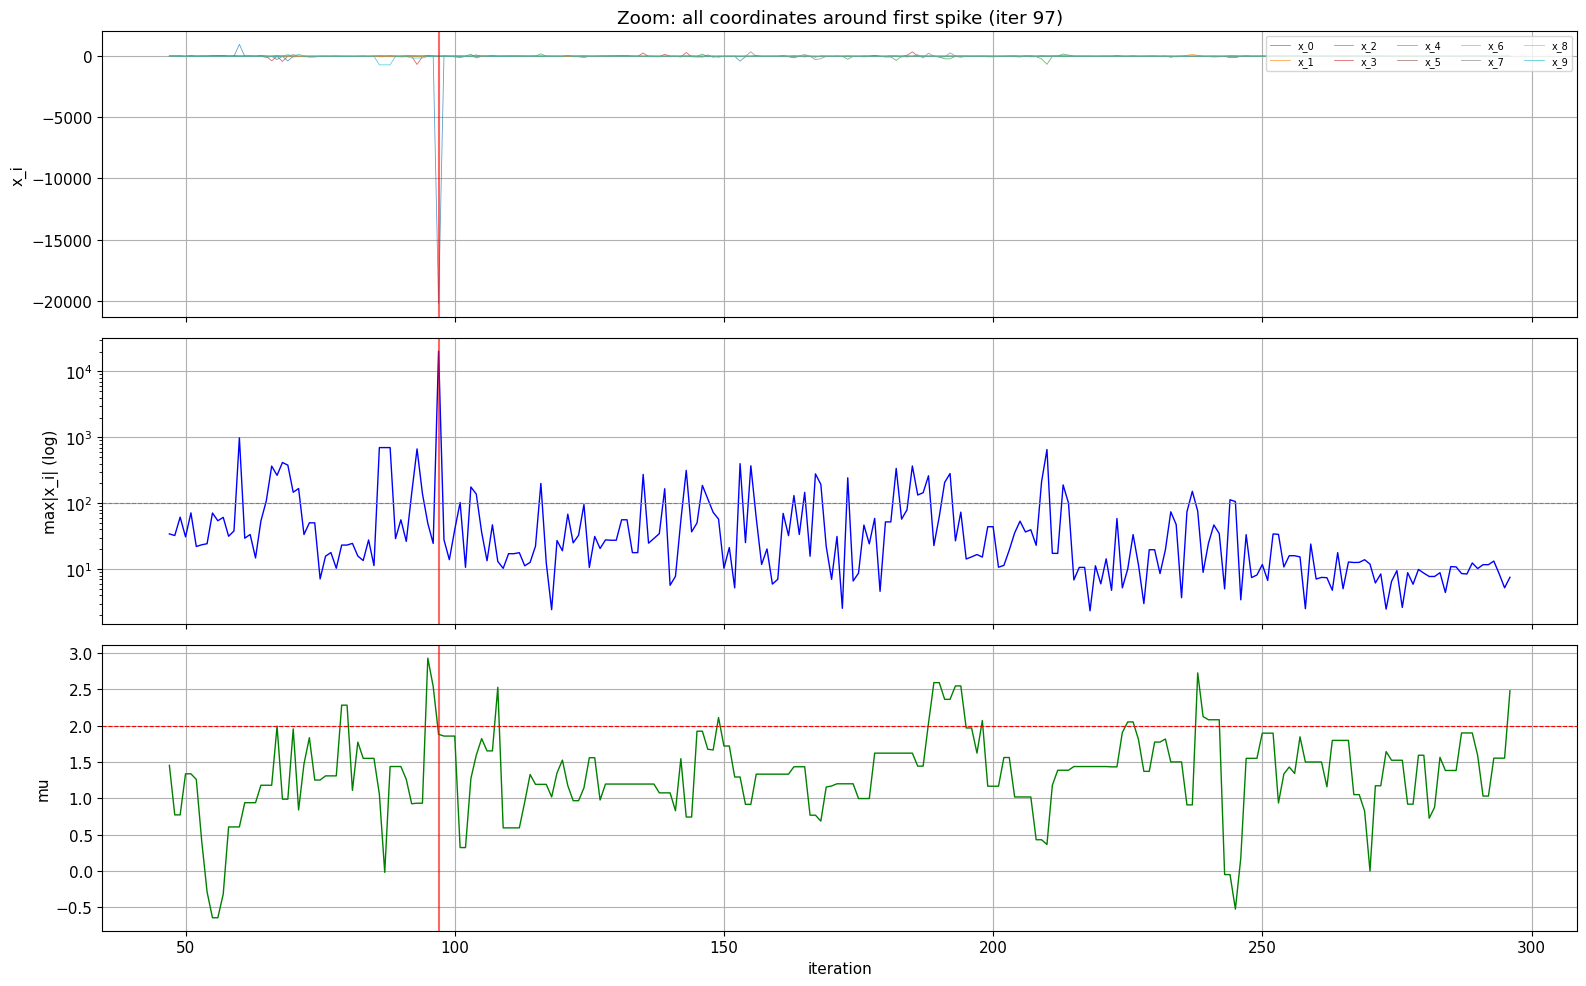

In [13]:
max_abs_per_iter = np.max(np.abs(x_chain), axis=1)
spike_iters = np.where(max_abs_per_iter > 1000)[0]

if len(spike_iters) > 0:
    first_spike = spike_iters[0]
    win_lo = max(0, first_spike - 50)
    win_hi = min(x_chain.shape[0], first_spike + 200)
    rng = np.arange(win_lo, win_hi)

    fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

    # All x_i values in the window
    for i in range(m_focus):
        axes[0].plot(rng, x_chain[win_lo:win_hi, i], lw=0.6, alpha=0.7, label=f'x_{i}')
    axes[0].axvline(first_spike, color='red', ls='-', lw=1.5, alpha=0.6)
    axes[0].set_ylabel('x_i')
    axes[0].set_title(f'Zoom: all coordinates around first spike (iter {first_spike})')
    axes[0].legend(fontsize=7, ncol=5, loc='upper right')

    # max|x| on log scale
    axes[1].semilogy(rng, max_abs_per_iter[win_lo:win_hi], 'b-', lw=1)
    axes[1].axvline(first_spike, color='red', ls='-', lw=1.5, alpha=0.6)
    axes[1].axhline(100, color='gray', ls='--', lw=0.8)
    axes[1].set_ylabel('max|x_i| (log)')

    # mu chain
    mu_chain_focus = r_focus['mu_chain']
    axes[2].plot(rng, mu_chain_focus[win_lo:win_hi], 'g-', lw=1)
    axes[2].axvline(first_spike, color='red', ls='-', lw=1.5, alpha=0.6)
    axes[2].axhline(mu_true, color='r', ls='--', lw=0.8)
    axes[2].set_ylabel('mu')
    axes[2].set_xlabel('iteration')

    # Which coordinate spiked?
    spike_x = x_chain[first_spike]
    spike_coord = np.argmax(np.abs(spike_x))
    print(f'Spike at iter {first_spike}: coordinate {spike_coord} = {spike_x[spike_coord]:.1f}')
    print(f'x before: {x_chain[first_spike-1]}')
    print(f'x after:  {x_chain[first_spike]}')
    print(f'mu at spike: {mu_chain_focus[first_spike]:.4f}')

    plt.tight_layout()
    plt.show()
else:
    print('No spikes above 1000 detected')

---
## 4. Multi-Seed Stability Test

The m=10, Wide prior run with seed=42 got stuck (post_mean=10.28). Is this a rare event or a systematic failure? Run 10 seeds for m=6 and m=10 with each prior and count "failures" (KL > 1).

In [14]:
n_seeds = 10
T_multi = 20000
burnin_multi = 2000
test_ms = [6, 10]
test_priors = {'Wide (std=10)': 10.0, 'Tight (std=3)': 3.0}

multi_rows = []

for m in test_ms:
    for prior_label, pstd in test_priors.items():
        print(f'\nm={m}, {prior_label}: running {n_seeds} seeds...')
        for s in range(n_seeds):
            # Different data per seed
            key = jrandom.PRNGKey(s * 100)
            key, subkey = jrandom.split(key)
            data_s = jrandom.t(subkey, df=k, shape=(m,)) + mu_true
            mle_s = utils.get_mle(data_s, {'k': k, 'm': m})

            params_s = {
                'k': k, 'm': m, 'num_iterations_T': T_multi,
                'prior_mean': 0.0, 'prior_std': pstd,
                'proposal_std_mu': 0.9, 'proposal_std_z': 0.03,
            }
            key_gibbs = jrandom.PRNGKey(s * 100 + 1)
            res_s = gs.run_gibbs_sampler_mle_jax(key_gibbs, mle_s, params_s)
            mu_post_s = np.array(res_s['mu_chain'])[burnin_multi:]
            x_chain_s = np.array(res_s['x_chain'])
            max_abs_s = np.max(np.abs(x_chain_s[burnin_multi:]), axis=1)

            z_acc_s = float(res_s['z_i_acceptance_rate'])
            ess_s = ess_from_chain(mu_post_s)

            multi_rows.append({
                'm': m, 'Prior': prior_label, 'seed': s,
                'MLE': f'{mle_s:.2f}',
                'post_mean': mu_post_s.mean(),
                'post_std': mu_post_s.std(),
                'max|x|': max_abs_s.max(),
                'pct_extreme': np.mean(max_abs_s > 100) * 100,
                'z_acc': z_acc_s,
                'ESS': ess_s,
            })
            print(f'  seed={s}: MLE={mle_s:.2f} post_mean={mu_post_s.mean():.2f}'
                  f' post_std={mu_post_s.std():.2f} z_acc={z_acc_s:.3f} ESS={ess_s:.0f}')

df_multi = pd.DataFrame(multi_rows)


m=6, Wide (std=10): running 10 seeds...


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1369.18it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6321
Z_i Acceptance Rate: 0.4366
  seed=0: MLE=2.66 post_mean=-6.13 post_std=10.40 z_acc=0.437 ESS=4


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1375.87it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6498
Z_i Acceptance Rate: 0.6503
  seed=1: MLE=1.76 post_mean=-3.22 post_std=6.28 z_acc=0.650 ESS=8


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1376.24it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6415
Z_i Acceptance Rate: 0.5563
  seed=2: MLE=1.50 post_mean=-4.37 post_std=9.80 z_acc=0.556 ESS=7


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1348.30it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6423
Z_i Acceptance Rate: 0.5746
  seed=3: MLE=1.69 post_mean=2.92 post_std=9.47 z_acc=0.575 ESS=6


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1343.65it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6400
Z_i Acceptance Rate: 0.5729
  seed=4: MLE=1.64 post_mean=0.68 post_std=10.87 z_acc=0.573 ESS=4


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1351.26it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6424
Z_i Acceptance Rate: 0.5805
  seed=5: MLE=1.12 post_mean=-5.71 post_std=6.59 z_acc=0.580 ESS=13


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1378.77it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6448
Z_i Acceptance Rate: 0.5902
  seed=6: MLE=1.34 post_mean=4.48 post_std=8.62 z_acc=0.590 ESS=8


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1376.10it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6353
Z_i Acceptance Rate: 0.5312
  seed=7: MLE=2.11 post_mean=6.59 post_std=9.88 z_acc=0.531 ESS=6


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1373.92it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6210
Z_i Acceptance Rate: 0.2099
  seed=8: MLE=18.29 post_mean=-7.74 post_std=8.86 z_acc=0.210 ESS=9


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1358.93it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6429
Z_i Acceptance Rate: 0.6151
  seed=9: MLE=2.27 post_mean=5.32 post_std=7.86 z_acc=0.615 ESS=6

m=6, Tight (std=3): running 10 seeds...


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1376.65it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6566
Z_i Acceptance Rate: 0.7537
  seed=0: MLE=2.66 post_mean=1.28 post_std=3.15 z_acc=0.754 ESS=17


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1370.72it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6594
Z_i Acceptance Rate: 0.7885
  seed=1: MLE=1.76 post_mean=1.01 post_std=2.01 z_acc=0.789 ESS=42


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1382.50it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6560
Z_i Acceptance Rate: 0.7649
  seed=2: MLE=1.50 post_mean=0.50 post_std=2.52 z_acc=0.765 ESS=41


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1380.03it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6518
Z_i Acceptance Rate: 0.7667
  seed=3: MLE=1.69 post_mean=1.13 post_std=2.49 z_acc=0.767 ESS=46


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1375.99it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6556
Z_i Acceptance Rate: 0.7815
  seed=4: MLE=1.64 post_mean=1.40 post_std=1.59 z_acc=0.782 ESS=171


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1376.61it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6595
Z_i Acceptance Rate: 0.7869
  seed=5: MLE=1.12 post_mean=0.58 post_std=2.10 z_acc=0.787 ESS=60


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1382.32it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6518
Z_i Acceptance Rate: 0.7913
  seed=6: MLE=1.34 post_mean=1.09 post_std=1.93 z_acc=0.791 ESS=98


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1381.66it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6555
Z_i Acceptance Rate: 0.7854
  seed=7: MLE=2.11 post_mean=1.37 post_std=2.12 z_acc=0.785 ESS=63


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1374.81it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6060
Z_i Acceptance Rate: 0.2255
  seed=8: MLE=18.29 post_mean=0.23 post_std=2.89 z_acc=0.225 ESS=59


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1342.57it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6585
Z_i Acceptance Rate: 0.7811
  seed=9: MLE=2.27 post_mean=1.00 post_std=2.71 z_acc=0.781 ESS=67

m=10, Wide (std=10): running 10 seeds...


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:15<00:00, 1297.79it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5538
Z_i Acceptance Rate: 0.5844
  seed=0: MLE=2.06 post_mean=-4.81 post_std=8.03 z_acc=0.584 ESS=5


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:15<00:00, 1331.04it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5641
Z_i Acceptance Rate: 0.7702
  seed=1: MLE=2.18 post_mean=2.70 post_std=2.11 z_acc=0.770 ESS=34


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1345.38it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5465
Z_i Acceptance Rate: 0.5277
  seed=2: MLE=1.66 post_mean=10.69 post_std=9.19 z_acc=0.528 ESS=3


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1345.95it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5298
Z_i Acceptance Rate: 0.2364
  seed=3: MLE=1.02 post_mean=-17.91 post_std=3.26 z_acc=0.236 ESS=20


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1347.94it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5619
Z_i Acceptance Rate: 0.7532
  seed=4: MLE=1.47 post_mean=1.39 post_std=3.95 z_acc=0.753 ESS=16


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1347.27it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5678
Z_i Acceptance Rate: 0.7103
  seed=5: MLE=2.29 post_mean=4.91 post_std=5.63 z_acc=0.710 ESS=6


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1339.28it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5648
Z_i Acceptance Rate: 0.7788
  seed=6: MLE=2.73 post_mean=2.94 post_std=1.33 z_acc=0.779 ESS=45


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1341.63it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5623
Z_i Acceptance Rate: 0.7698
  seed=7: MLE=1.76 post_mean=1.71 post_std=0.85 z_acc=0.770 ESS=664


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1341.28it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5376
Z_i Acceptance Rate: 0.4405
  seed=8: MLE=2.18 post_mean=-8.58 post_std=8.29 z_acc=0.441 ESS=4


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1341.52it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5638
Z_i Acceptance Rate: 0.7843
  seed=9: MLE=1.99 post_mean=1.93 post_std=0.86 z_acc=0.784 ESS=442

m=10, Tight (std=3): running 10 seeds...


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1349.45it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5587
Z_i Acceptance Rate: 0.7847
  seed=0: MLE=2.06 post_mean=1.96 post_std=0.86 z_acc=0.785 ESS=369


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1338.70it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5615
Z_i Acceptance Rate: 0.7803
  seed=1: MLE=2.18 post_mean=1.94 post_std=1.16 z_acc=0.780 ESS=75


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1343.53it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5591
Z_i Acceptance Rate: 0.7831
  seed=2: MLE=1.66 post_mean=1.58 post_std=0.77 z_acc=0.783 ESS=509


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1345.84it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5566
Z_i Acceptance Rate: 0.7777
  seed=3: MLE=1.02 post_mean=0.55 post_std=1.65 z_acc=0.778 ESS=27


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1343.11it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5497
Z_i Acceptance Rate: 0.7812
  seed=4: MLE=1.47 post_mean=1.30 post_std=1.02 z_acc=0.781 ESS=160


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1335.68it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5612
Z_i Acceptance Rate: 0.7696
  seed=5: MLE=2.29 post_mean=1.92 post_std=1.42 z_acc=0.770 ESS=58


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1343.72it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5551
Z_i Acceptance Rate: 0.7870
  seed=6: MLE=2.73 post_mean=2.59 post_std=0.83 z_acc=0.787 ESS=556


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:14<00:00, 1343.12it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5586
Z_i Acceptance Rate: 0.7633
  seed=7: MLE=1.76 post_mean=1.67 post_std=1.01 z_acc=0.763 ESS=158


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:15<00:00, 1326.91it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5579
Z_i Acceptance Rate: 0.7758
  seed=8: MLE=2.18 post_mean=1.54 post_std=2.03 z_acc=0.776 ESS=33


Running Gibbs Sampler: 100%|██████████| 20000/20000 [00:15<00:00, 1270.95it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.5585
Z_i Acceptance Rate: 0.7925
  seed=9: MLE=1.99 post_mean=1.91 post_std=0.83 z_acc=0.793 ESS=390


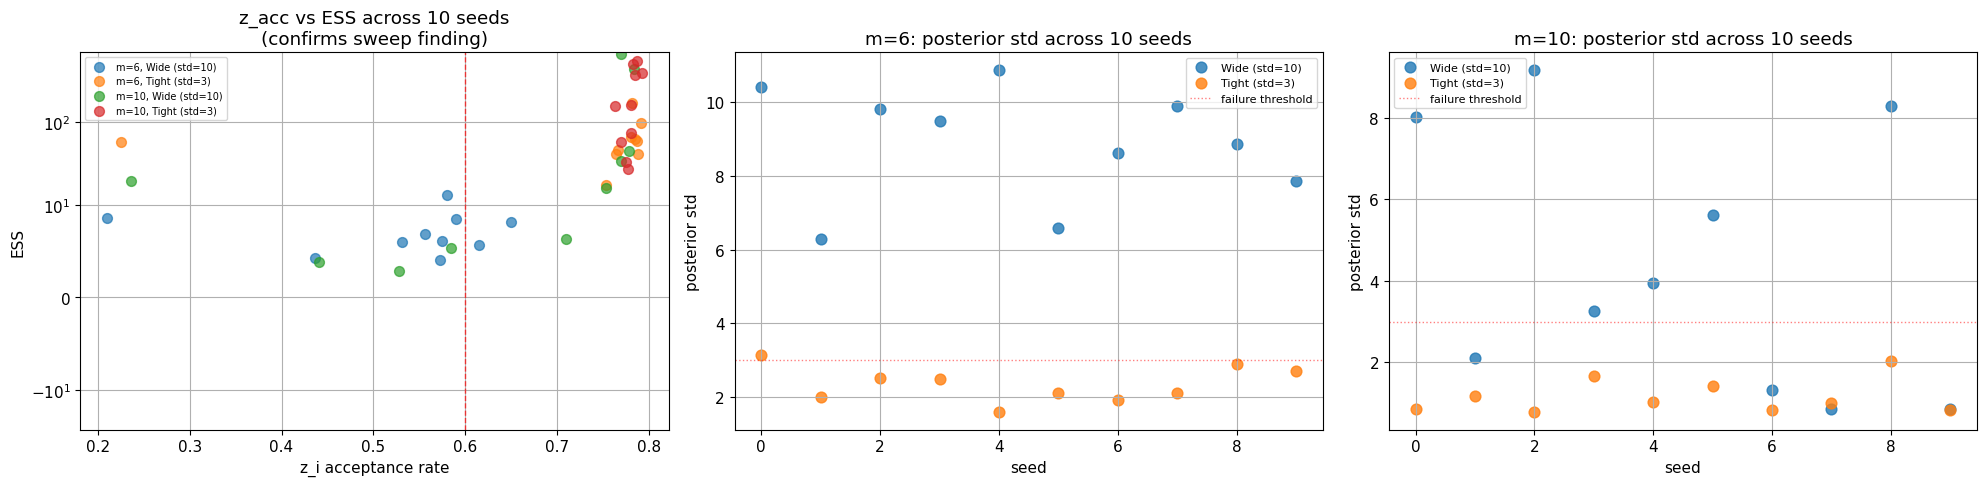

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# (a) z_acc vs ESS across all multi-seed runs — confirms sweep finding
for m_val in test_ms:
    for prior_label in test_priors:
        subset = df_multi[(df_multi['m'] == m_val) & (df_multi['Prior'] == prior_label)]
        axes[0].scatter(subset['z_acc'], subset['ESS'], s=50, alpha=0.7,
                        label=f'm={m_val}, {prior_label}')

axes[0].axvline(0.6, color='r', ls='--', lw=1, alpha=0.7)
axes[0].set_xlabel('z_i acceptance rate')
axes[0].set_ylabel('ESS')
axes[0].set_title(f'z_acc vs ESS across {n_seeds} seeds\n(confirms sweep finding)')
axes[0].legend(fontsize=7)
axes[0].set_yscale('symlog', linthresh=10)

# (b) posterior std across seeds
for idx, m_val in enumerate(test_ms):
    ax = axes[idx + 1]
    for prior_label in test_priors:
        subset = df_multi[(df_multi['m'] == m_val) & (df_multi['Prior'] == prior_label)]
        ax.scatter(subset['seed'], subset['post_std'], s=60, label=prior_label, alpha=0.8)
    ax.axhline(3.0, color='r', ls=':', lw=1, alpha=0.5, label='failure threshold')
    ax.set_xlabel('seed')
    ax.set_ylabel('posterior std')
    ax.set_title(f'm={m_val}: posterior std across {n_seeds} seeds')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [16]:
print('Multi-seed stability summary:')
print('=' * 80)
for m in test_ms:
    for prior_label in test_priors:
        subset = df_multi[(df_multi['m'] == m) & (df_multi['Prior'] == prior_label)]
        n_fail = (subset['post_std'] > 3.0).sum()
        med_std = subset['post_std'].median()
        max_std = subset['post_std'].max()
        med_zacc = subset['z_acc'].median()
        med_ess = subset['ESS'].median()
        n_low_zacc = (subset['z_acc'] < 0.6).sum()
        print(f'm={m:2d} {prior_label:18s} | std_fail={n_fail}/{n_seeds}'
              f' med_std={med_std:.2f} med_z_acc={med_zacc:.3f}'
              f' low_z_acc={n_low_zacc}/{n_seeds} med_ESS={med_ess:.0f}')

Multi-seed stability summary:
m= 6 Wide (std=10)      | std_fail=10/10 med_std=9.17 med_z_acc=0.574 low_z_acc=8/10 med_ESS=6
m= 6 Tight (std=3)      | std_fail=1/10 med_std=2.30 med_z_acc=0.781 low_z_acc=1/10 med_ESS=60
m=10 Wide (std=10)      | std_fail=6/10 med_std=3.60 med_z_acc=0.732 low_z_acc=4/10 med_ESS=18
m=10 Tight (std=3)      | std_fail=0/10 med_std=1.01 med_z_acc=0.781 low_z_acc=0/10 med_ESS=159


---
## 5. Can We Fix Mode 1? Proposal Step-Size Tuning

Mode 1 failures are driven by low z_i acceptance rate. The z-proposals use `proposal_std_z` = 0.03 (default). If this step-size is too large for the U-shaped q(z), the proposals overshoot and get rejected. If too small, the chain barely moves.

Sweep `proposal_std_z` over a range and measure z_acc and ESS at the worst-case configurations (m=6/Flat and m=10/Wide).

In [17]:
sigma_z_vals = [0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.2]
tuning_configs = [
    (6,  'Flat (std=20)', 20.0),
    (6,  'Tight (std=3)',  3.0),
    (10, 'Wide (std=10)', 10.0),
    (10, 'Tight (std=3)',  3.0),
]

T_tune = 15000
burnin_tune = 2000
tuning_rows = []

for m_t, prior_label, pstd in tuning_configs:
    key_t = jrandom.PRNGKey(seed)
    key_t, subkey = jrandom.split(key_t)
    data_t = jrandom.t(subkey, df=k, shape=(m_t,)) + mu_true
    mle_t = utils.get_mle(data_t, {'k': k, 'm': m_t})
    
    print(f'\nm={m_t}, {prior_label} (MLE={mle_t:.3f})')
    for sz in sigma_z_vals:
        params_t = {
            'k': k, 'm': m_t, 'num_iterations_T': T_tune,
            'prior_mean': 0.0, 'prior_std': pstd,
            'proposal_std_mu': 0.9, 'proposal_std_z': sz,
        }
        key_gibbs = jrandom.PRNGKey(seed + 7)
        res_t = gs.run_gibbs_sampler_mle_jax(key_gibbs, mle_t, params_t)
        mu_post_t = np.array(res_t['mu_chain'])[burnin_tune:]
        z_acc_t = float(res_t['z_i_acceptance_rate'])
        ess_t = ess_from_chain(mu_post_t)
        var_t = mu_post_t.var()
        
        tuning_rows.append({
            'm': m_t, 'Prior': prior_label, 'sigma_z': sz,
            'z_acc': z_acc_t, 'ESS': ess_t, 'post_std': mu_post_t.std(),
        })
        print(f'  σ_z={sz:.3f} → z_acc={z_acc_t:.3f}  ESS={ess_t:6.0f}  post_std={mu_post_t.std():.2f}')

df_tune = pd.DataFrame(tuning_rows)


m=6, Flat (std=20) (MLE=1.878)


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1319.45it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6554
Z_i Acceptance Rate: 0.9014
  σ_z=0.005 → z_acc=0.901  ESS=     8  post_std=4.17


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1348.37it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6186
Z_i Acceptance Rate: 0.5539
  σ_z=0.010 → z_acc=0.554  ESS=     7  post_std=7.12


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1344.33it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6198
Z_i Acceptance Rate: 0.4532
  σ_z=0.020 → z_acc=0.453  ESS=    12  post_std=7.12


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1360.67it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6271
Z_i Acceptance Rate: 0.4470
  σ_z=0.030 → z_acc=0.447  ESS=     4  post_std=11.63


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1336.41it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6400
Z_i Acceptance Rate: 0.4207
  σ_z=0.050 → z_acc=0.421  ESS=     3  post_std=10.85


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:10<00:00, 1369.50it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6253
Z_i Acceptance Rate: 0.2234
  σ_z=0.080 → z_acc=0.223  ESS=     5  post_std=9.44


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1357.80it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6287
Z_i Acceptance Rate: 0.2598
  σ_z=0.120 → z_acc=0.260  ESS=     3  post_std=13.13


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1359.39it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6333
Z_i Acceptance Rate: 0.3376
  σ_z=0.200 → z_acc=0.338  ESS=     7  post_std=9.25

m=6, Tight (std=3) (MLE=1.878)


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:10<00:00, 1370.95it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6543
Z_i Acceptance Rate: 0.9349
  σ_z=0.005 → z_acc=0.935  ESS=     8  post_std=2.54


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1363.49it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6508
Z_i Acceptance Rate: 0.8786
  σ_z=0.010 → z_acc=0.879  ESS=    23  post_std=1.96


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1344.50it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6508
Z_i Acceptance Rate: 0.8163
  σ_z=0.020 → z_acc=0.816  ESS=    43  post_std=2.16


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1330.95it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6497
Z_i Acceptance Rate: 0.7766
  σ_z=0.030 → z_acc=0.777  ESS=    43  post_std=2.24


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1348.71it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6539
Z_i Acceptance Rate: 0.7231
  σ_z=0.050 → z_acc=0.723  ESS=   120  post_std=1.74


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:13<00:00, 1143.30it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6536
Z_i Acceptance Rate: 0.6822
  σ_z=0.080 → z_acc=0.682  ESS=   166  post_std=1.79


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:10<00:00, 1365.49it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6554
Z_i Acceptance Rate: 0.6401
  σ_z=0.120 → z_acc=0.640  ESS=   106  post_std=1.89


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:10<00:00, 1375.63it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6479
Z_i Acceptance Rate: 0.6126
  σ_z=0.200 → z_acc=0.613  ESS=   140  post_std=1.70

m=10, Wide (std=10) (MLE=1.420)


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1320.68it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5481
Z_i Acceptance Rate: 0.8316
  σ_z=0.005 → z_acc=0.832  ESS=     3  post_std=3.09


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1282.18it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5504
Z_i Acceptance Rate: 0.7047
  σ_z=0.010 → z_acc=0.705  ESS=     4  post_std=9.06


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:12<00:00, 1210.08it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5244
Z_i Acceptance Rate: 0.3185
  σ_z=0.020 → z_acc=0.319  ESS=    38  post_std=2.80


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1332.23it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5568
Z_i Acceptance Rate: 0.5947
  σ_z=0.030 → z_acc=0.595  ESS=     3  post_std=8.22


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1351.08it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5486
Z_i Acceptance Rate: 0.5084
  σ_z=0.050 → z_acc=0.508  ESS=     3  post_std=9.26


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1358.49it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5565
Z_i Acceptance Rate: 0.6334
  σ_z=0.080 → z_acc=0.633  ESS=     8  post_std=3.67


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1362.77it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5477
Z_i Acceptance Rate: 0.4368
  σ_z=0.120 → z_acc=0.437  ESS=     3  post_std=9.20


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1309.40it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5480
Z_i Acceptance Rate: 0.3313
  σ_z=0.200 → z_acc=0.331  ESS=     3  post_std=8.98

m=10, Tight (std=3) (MLE=1.420)


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1318.67it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5558
Z_i Acceptance Rate: 0.9209
  σ_z=0.005 → z_acc=0.921  ESS=     3  post_std=3.12


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1261.33it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5511
Z_i Acceptance Rate: 0.8615
  σ_z=0.010 → z_acc=0.862  ESS=     3  post_std=3.77


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1303.75it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5498
Z_i Acceptance Rate: 0.8118
  σ_z=0.020 → z_acc=0.812  ESS=   585  post_std=0.72


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1352.53it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5547
Z_i Acceptance Rate: 0.7858
  σ_z=0.030 → z_acc=0.786  ESS=   251  post_std=0.84


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1355.16it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5556
Z_i Acceptance Rate: 0.7341
  σ_z=0.050 → z_acc=0.734  ESS=   409  post_std=0.85


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1359.38it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5599
Z_i Acceptance Rate: 0.6813
  σ_z=0.080 → z_acc=0.681  ESS=    72  post_std=1.24


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1359.19it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5573
Z_i Acceptance Rate: 0.6522
  σ_z=0.120 → z_acc=0.652  ESS=    70  post_std=1.34


Running Gibbs Sampler: 100%|██████████| 15000/15000 [00:11<00:00, 1351.90it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.5536
Z_i Acceptance Rate: 0.6232
  σ_z=0.200 → z_acc=0.623  ESS=   342  post_std=0.86


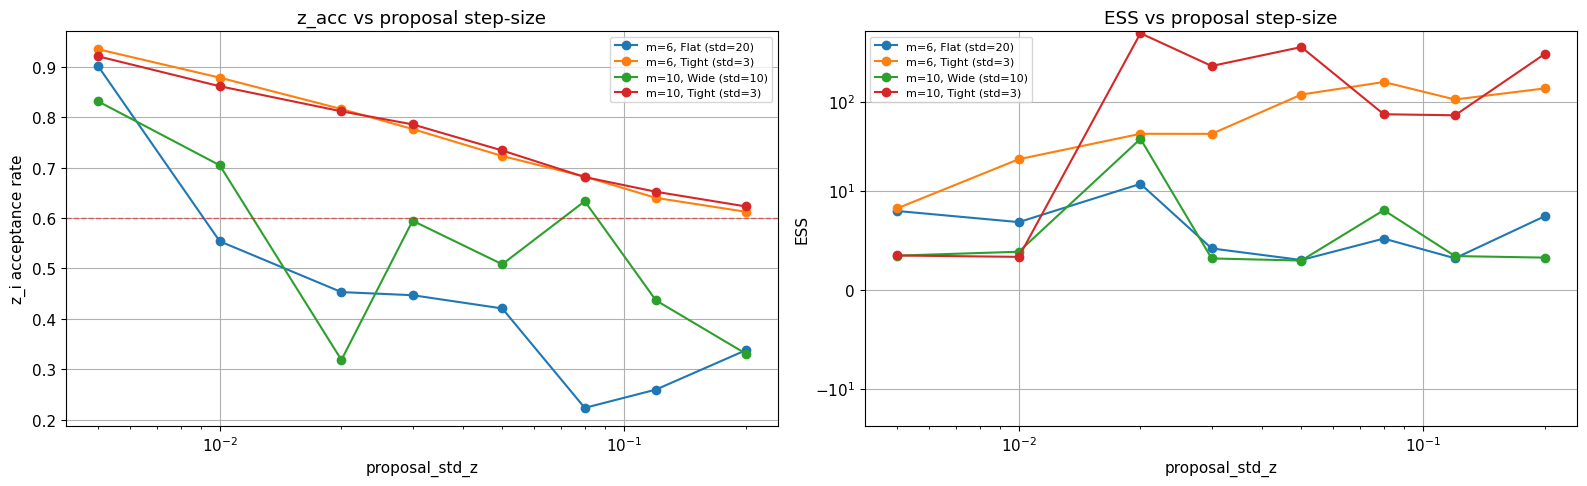

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for m_t, prior_label, _ in tuning_configs:
    sub = df_tune[(df_tune['m'] == m_t) & (df_tune['Prior'] == prior_label)]
    label = f'm={m_t}, {prior_label}'
    axes[0].plot(sub['sigma_z'], sub['z_acc'], 'o-', label=label, markersize=6)
    axes[1].plot(sub['sigma_z'], sub['ESS'], 'o-', label=label, markersize=6)

axes[0].set_xlabel('proposal_std_z')
axes[0].set_ylabel('z_i acceptance rate')
axes[0].set_title('z_acc vs proposal step-size')
axes[0].axhline(0.6, color='r', ls='--', lw=1, alpha=0.5)
axes[0].set_xscale('log')
axes[0].legend(fontsize=8)

axes[1].set_xlabel('proposal_std_z')
axes[1].set_ylabel('ESS')
axes[1].set_title('ESS vs proposal step-size')
axes[1].set_xscale('log')
axes[1].set_yscale('symlog', linthresh=10)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

### 5b. Does running a longer chain fix m=6?

At m=6, even Tight prior only gets ESS ~77 from 30K iterations. If ESS scales linearly with chain length, we'd need ~10x more iterations for ESS ~770. Test this with T=150K to see if the posterior actually converges.

Running Gibbs Sampler: 100%|██████████| 150000/150000 [02:21<00:00, 1059.68it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6366
Z_i Acceptance Rate: 0.4788
Flat (std=20): z_acc=0.479  ESS=17 / 145000  post_std=15.36


Running Gibbs Sampler: 100%|██████████| 150000/150000 [02:20<00:00, 1067.16it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.6542
Z_i Acceptance Rate: 0.7725
Tight (std=3): z_acc=0.772  ESS=286 / 145000  post_std=2.29


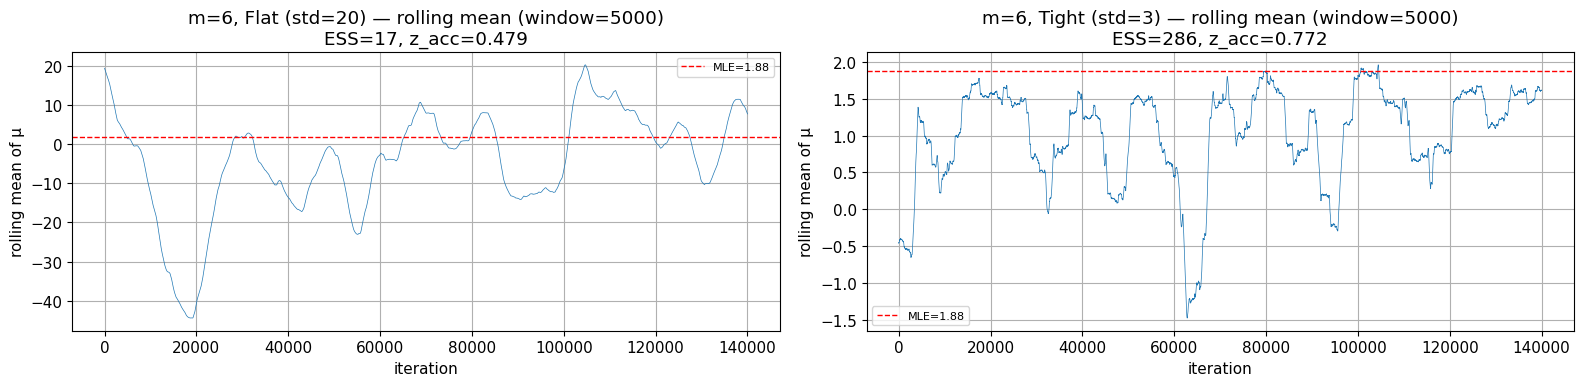

In [19]:
T_long = 150000
burnin_long = 5000

key_long = jrandom.PRNGKey(seed)
key_long, subkey = jrandom.split(key_long)
data_long = jrandom.t(subkey, df=k, shape=(6,)) + mu_true
mle_long = utils.get_mle(data_long, {'k': k, 'm': 6})

long_results = {}
for prior_label, pstd in [('Flat (std=20)', 20.0), ('Tight (std=3)', 3.0)]:
    params_long = {
        'k': k, 'm': 6, 'num_iterations_T': T_long,
        'prior_mean': 0.0, 'prior_std': pstd,
        'proposal_std_mu': 0.9, 'proposal_std_z': 0.03,
    }
    key_gibbs = jrandom.PRNGKey(seed + 99)
    res_long = gs.run_gibbs_sampler_mle_jax(key_gibbs, mle_long, params_long)
    mu_post_long = np.array(res_long['mu_chain'])[burnin_long:]
    z_acc_long = float(res_long['z_i_acceptance_rate'])
    ess_long = ess_from_chain(mu_post_long)
    long_results[prior_label] = {'mu_post': mu_post_long, 'z_acc': z_acc_long, 'ess': ess_long}
    print(f'{prior_label}: z_acc={z_acc_long:.3f}  ESS={ess_long:.0f} / {T_long - burnin_long}'
          f'  post_std={mu_post_long.std():.2f}')

# Compare rolling posterior mean to check convergence
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
for ax, (label, r) in zip(axes, long_results.items()):
    chain = r['mu_post']
    window = 5000
    rolling_mean = np.convolve(chain, np.ones(window)/window, mode='valid')
    ax.plot(rolling_mean, lw=0.5)
    ax.axhline(mle_long, color='r', ls='--', lw=1, label=f'MLE={mle_long:.2f}')
    ax.set_title(f'm=6, {label} — rolling mean (window={window})\nESS={r["ess"]:.0f}, z_acc={r["z_acc"]:.3f}')
    ax.set_xlabel('iteration')
    ax.set_ylabel('rolling mean of μ')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()